In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext lab_black

In [2]:
from src.parameters import PROCESSED_DATA_DIR
from src.analysis import highest_posterior_density
import os
import pandas as pd
import xarray as xr
import numpy as np
from tqdm.auto import tqdm


def _preprocess(replay_info):
    N_UNIQUE_SPIKING = 2
    replay_info = replay_info.set_index(
        ["animal", "day", "epoch", "ripple_number"]
    ).rename_axis(index={"animal": "Animal ID"})
    replay_info = replay_info.loc[
        replay_info.n_unique_spiking >= N_UNIQUE_SPIKING
    ].sort_index()
    return replay_info


def load_replay_info(epoch_key):
    animal, day, epoch = epoch_key
    data_type, dim = "clusterless", "1D"

    file_path = os.path.join(
        PROCESSED_DATA_DIR,
        f"{animal}_{day:02d}_{epoch:02}_{data_type}_{dim}_replay_info.csv",
    )
    return _preprocess(pd.read_csv(file_path))


def get_shuffle_results(epoch_key, shuffle_ind):
    animal, day, epoch = epoch_key
    data_type, dim = "clusterless", "1D"
    group = f"/{data_type}/{dim}/classifier/shuffle/shuffle_{shuffle_ind:02d}"
    filename = os.path.join(
        PROCESSED_DATA_DIR, "shuffle", f"{animal}_{day:02d}_{epoch:02d}.nc"
    )

    return xr.open_dataset(filename, group=group, autoclose=True)


def get_avg_shuffle_spatial_coverage(epoch_key):
    N_SHUFFLES = 50
    HPD_PCT = 0.95

    avg_shuffle_spatial_coverage = []

    for shuffle_ind in tqdm(range(N_SHUFFLES)):
        shuffle_spatial_coverage = []

        results = get_shuffle_results(
            epoch_key, shuffle_ind=shuffle_ind
        ).acausal_posterior

        for ripple_number in results.ripple_number:
            posterior = results.sel(ripple_number=ripple_number).dropna(
                "time", how="all"
            )
            hpd_threshold = highest_posterior_density(
                posterior.sum("state"), coverage=HPD_PCT
            )
            isin_hpd = posterior.sum("state") >= hpd_threshold[:, np.newaxis]
            spatial_coverage = (
                (isin_hpd * np.diff(posterior.position)[0]).sum("position").values
            )

            shuffle_spatial_coverage.append(spatial_coverage.mean())

        avg_shuffle_spatial_coverage.append(shuffle_spatial_coverage)

    return np.asarray(avg_shuffle_spatial_coverage)

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_HPD(epoch_key, ax):
    avg_shuffle_spatial_coverage = get_avg_shuffle_spatial_coverage(epoch_key).mean(
        axis=1
    )
    replay_info = load_replay_info(epoch_key)
    avg_spatial_coverage = replay_info.spatial_coverage.mean()

    sns.distplot(avg_shuffle_spatial_coverage, color="lightgrey", ax=ax)
    ax.axvline(avg_spatial_coverage, color="red", clip_on=False)
    ax.set_xlabel("Spatial Coverage [cm]")
    ax.set_xlim((0.0, 350.0))
    ax.set_xticks(np.arange(0, 400, 100))
    sns.despine(left=True)

    N_SHUFFLES = 50
    animal, day, epoch = epoch_key
    print(epoch_key)
    print(f"n_ripples = {replay_info.shape[0]}")
    print(
        f"mean shuffle spatial coverage = {np.mean(avg_shuffle_spatial_coverage):.0f} cm"
    )
    print(f"mean spatial coverage = {avg_spatial_coverage:.0f} cm")
    print(
        f"p-value = {(np.sum(avg_spatial_coverage >= avg_shuffle_spatial_coverage) + 1) / (N_SHUFFLES + 1):0.2f}"
    )
    print("\n")


('bon', 3, 2)
n_ripples = 251
mean shuffle spatial coverage = 229 cm
mean spatial coverage = 55 cm
p-value = 0.02





('remy', 35, 2)
n_ripples = 344
mean shuffle spatial coverage = 231 cm
mean spatial coverage = 72 cm
p-value = 0.02




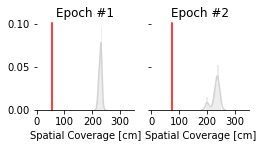

In [26]:
from src.figure_utilities import ONE_COLUMN, PAGE_HEIGHT, save_figure


fig, axes = plt.subplots(
    1, 2, figsize=(ONE_COLUMN, PAGE_HEIGHT / 5), constrained_layout=True, sharey=True,
)
epoch_keys = [("bon", 3, 2), ("remy", 35, 2)]

for epoch_ind, (ax, epoch_key) in enumerate(zip(axes.flat, epoch_keys)):
    plot_HPD(epoch_key, ax)
    ax.set_title(f"Epoch #{epoch_ind + 1}")

save_figure(os.path.join("Figure4-supplemental1", "figure4-supplemental1_HPD"))